Import necessary libraries

In [17]:
from sklearn.model_selection import train_test_split
from google.colab import drive
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats

Mount the google drive to load the CSV

In [18]:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load the dataset from Google Drive into a pandas DataFrame and then drop rows with missing values in the 'CME_speed' or 'Time_diff_hours' columns.

In [19]:
df = pd.read_csv('/content/drive/MyDrive/cme_ips_data.csv')
df = df.dropna(subset=['CME_speed', 'Time_diff_hours'])

Generate a scatter plot of 'CME_speed' versus 'Time_diff_hours' and overlay a LOWESS regression line to visualize the relationship between the two variables.

<Axes: xlabel='CME_speed', ylabel='Time_diff_hours'>

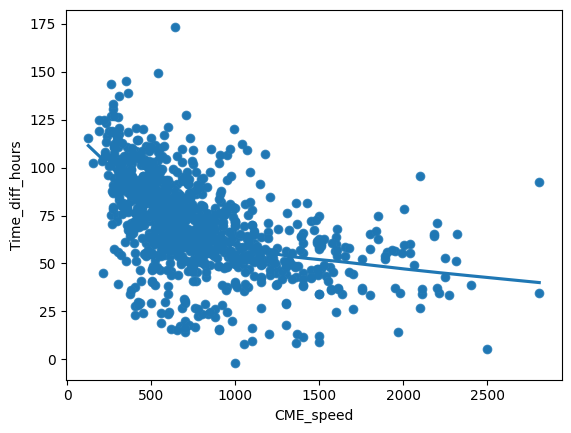

In [20]:

sns.scatterplot(x='CME_speed', y='Time_diff_hours', data=df)
sns.regplot(x='CME_speed', y='Time_diff_hours', data=df, lowess=True)

Function to print the necessary metrics

In [21]:
def print_metrics(y_true, y_pred, name):
    print(f"--- {name} ---")
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("R²:", r2)
    print()

Prepare the data into NumPy arrays.

In [22]:
# Prepare data
X = df['CME_speed'].values
y = df['Time_diff_hours'].values

Split the data into training and testing sets using a 80/20 ratio, with a fixed random state for reproducibility.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Define a power law function `a * x^b`, which will be used to model the relationship between CME speed and time difference.

In [24]:
def power_law(x, a, b):
    return a * np.power(x, b)

Fir the power law model.

In [25]:
print("\nFitting power law model (Train set)...")
initial_guess = [1000.0, -0.5]  # [a, b]
params_pw, cov_pw = curve_fit(
    power_law, X_train, y_train, p0=initial_guess, maxfev=5000
)

a_pw, b_pw = params_pw
a_err, b_err = np.sqrt(np.diag(cov_pw))

print(f"Fitted parameters:")
print(f"  a = {a_pw:.3f} ± {a_err:.3f}")
print(f"  b = {b_pw:.3f} ± {b_err:.3f}")
print(f"Model: Time_diff = {a_pw:.3f} × Speed^{b_pw:.3f}")


Fitting power law model (Train set)...
Fitted parameters:
  a = 866.112 ± 112.536
  b = -0.387 ± 0.020
Model: Time_diff = 866.112 × Speed^-0.387


Generate predictions and print the metrics for both training and test data.

In [26]:
# Predictions
y_train_pred = power_law(X_train, *params_pw)
y_test_pred  = power_law(X_test, *params_pw)

# Metrics
print("\nModel Evaluation Metrics:")
print_metrics(y_train, y_train_pred, "Training Data (Power Law)")
print_metrics(y_test, y_test_pred, "Test Data (Power Law)")


Model Evaluation Metrics:
--- Training Data (Power Law) ---
MAE: 14.745713973675404
RMSE: 20.03474906864452
R²: 0.3139501493165485

--- Test Data (Power Law) ---
MAE: 14.194230478294966
RMSE: 18.878300698853657
R²: 0.3532961861238716



Generate a plot to visualize the power law fit on the training and test data, and a second plot showing the residuals of the model on the test data.

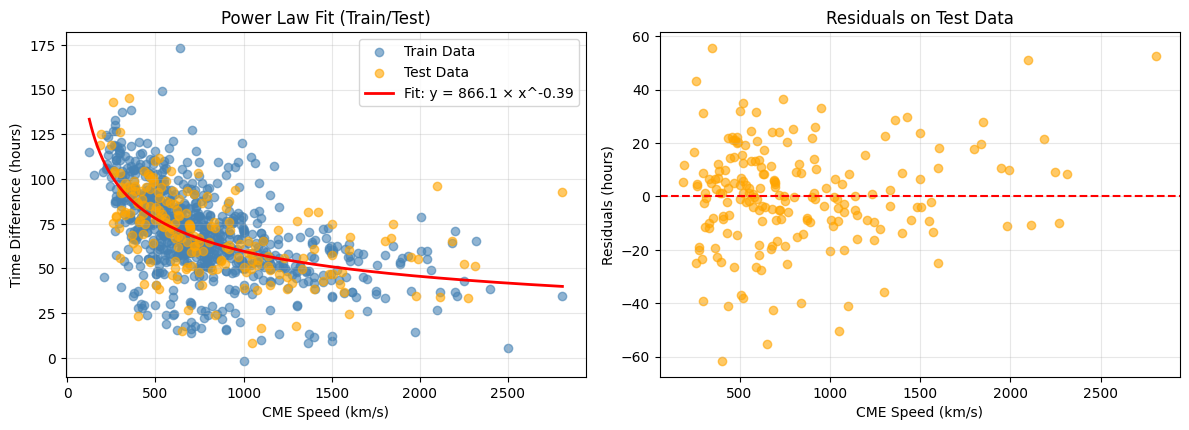

In [27]:
plt.figure(figsize=(12,8))

# Train + test with fit curve
plt.subplot(2,2,1)
plt.scatter(X_train, y_train, alpha=0.6, color='steelblue', label='Train Data')
plt.scatter(X_test, y_test, alpha=0.6, color='orange', label='Test Data')
X_smooth = np.linspace(X.min(), X.max(), 500)
plt.plot(X_smooth, power_law(X_smooth, *params_pw), 'r-', linewidth=2,
         label=f'Fit: y = {a_pw:.1f} × x^{b_pw:.2f}')
plt.xlabel('CME Speed (km/s)')
plt.ylabel('Time Difference (hours)')
plt.title('Power Law Fit (Train/Test)')
plt.legend()
plt.grid(alpha=0.3)

# Residuals
plt.subplot(2,2,2)
residuals = y_test - y_test_pred
plt.scatter(X_test, residuals, alpha=0.6, color='orange')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('CME Speed (km/s)')
plt.ylabel('Residuals (hours)')
plt.title('Residuals on Test Data')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Sample predictions using trained power law model.

In [28]:
example_speeds = [500, 1000, 1500, 2000]
print("\nExample Predictions (Power Law):")
for speed in example_speeds:
    pred_time = power_law(speed, *params_pw)
    print(f"  CME Speed {speed} km/s → Predicted Time: {pred_time:.1f} hours")


Example Predictions (Power Law):
  CME Speed 500 km/s → Predicted Time: 78.0 hours
  CME Speed 1000 km/s → Predicted Time: 59.6 hours
  CME Speed 1500 km/s → Predicted Time: 50.9 hours
  CME Speed 2000 km/s → Predicted Time: 45.6 hours
